In [138]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import controllers
import numpy as np
import json
import pandas as pd
import controllers
import synthetics
import os
import datetime as dt

In [139]:
def clamp(x, x_min, x_max):
    """Clamps number x between x_min and x_max"""
    if x > x_max:
        return x_max
    if x < x_min:
        return x_min
    return x

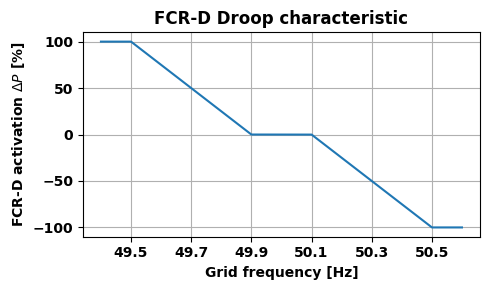

In [140]:
droop = controllers.DroopController(0.4e-2,50,0.1)
fs = np.linspace(49.4,50.6,1000)
activation = [clamp(droop.update(f),-100,100) for f in fs]
plt.figure(figsize=(5,3))
plt.plot(fs,activation)
plt.title('FCR-D Droop characteristic',weight='bold')
plt.xlabel('Grid frequency [Hz]',weight='bold')
plt.ylabel(r'FCR-D activation $\Delta P$ [%]',weight='bold')
plt.xticks([49.5,49.7,49.9,50.1,50.3,50.5],weight='bold')
plt.yticks(weight='bold')
plt.grid(True)
plt.tight_layout()

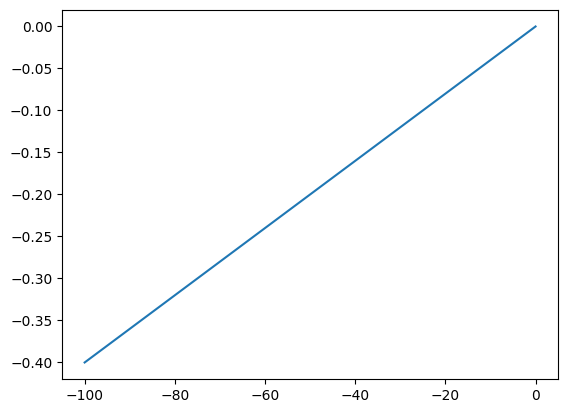

In [141]:
plt.figure()
R = 0.4e-2
activations = np.linspace(0,-100,1000)
fs = R*activations
plt.plot(activations,fs)

In [142]:
filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()


In [145]:
test = synthetics.FastRampTest(start)
active_bid = 0.75
ts = np.arange(start,stop,dt.timedelta(seconds=0.1)).astype(dt.datetime)
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df*R,-active_bid,0) for df in dfs])

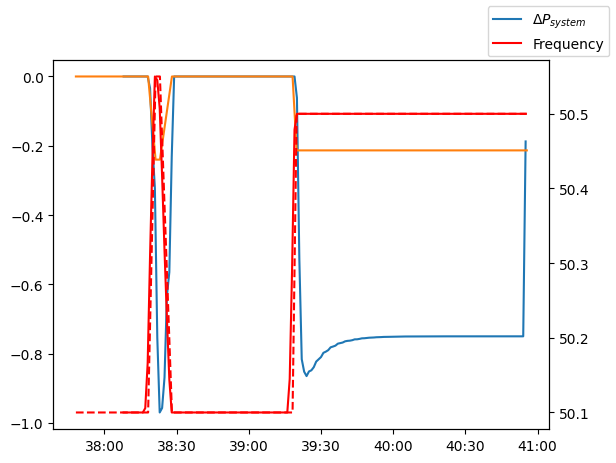

In [ ]:
fig,ax1 = plt.subplots()

ax1.plot(df_resampled.index,df_resampled['delta P system@supervisor'],label = r'$\Delta P_{system}$')
ax1.plot(ts,dPs)
ax2 = ax1.twinx()
#ax2.plot(df_resampled.index,df_resampled['frequency@supervisor'],label = r'Frequency',color='r')
#ax2.plot(ts,fs,linestyle='--',color='r')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
fig.legend()